In [6]:
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Чтение данных из JSON файла
file_path = 'pm_vk_wall.json'  # путь к файлу
with open(file_path, 'r', encoding='utf-8') as f:
    vk_data = json.load(f)

posts = []
for post in vk_data:
    # Извлечение нужных полей из постов
    posts.append({
        'likes_count': post.get('likes', {}).get('count', 0),
        'comments_count': post.get('comments', {}).get('count', 0),
        'reposts_count': post.get('reposts', {}).get('count', 0),
        'views_count': post.get('views', {}).get('count', 0),
        'attachments_count': len(post.get('attachments', [])),
        'text_length': len(post.get('text', '')),
        'has_attachments': 1 if post.get('attachments') else 0,
        'platform': post.get('post_source', {}).get('platform', 'unknown'),
        'is_donut': 1 if post.get('donut', {}).get('is_donut', False) else 0,
        'post_date': post.get('date', 0),
    })
df = pd.DataFrame(posts)    # Преобразование данных в DataFrame
scaler = StandardScaler()   
numerical_features = ['likes_count', 'comments_count', 'reposts_count', 'views_count', 'attachments_count', 'text_length', 'post_date']
df[numerical_features] = scaler.fit_transform(df[numerical_features])  # Нормализация числовых признаков (кроме категориальных, таких как платформа)
df.head()

,likes_count,comments_count,reposts_count,views_count,attachments_count,text_length,has_attachments,platform,is_donut,post_date
0,2.437374,0.489365,1.150825,0.937108,0.578613,-0.265111,1,iphone,0,1.141870
1,-0.907849,-0.238972,-0.134222,-0.476778,-0.201339,-0.274706,1,iphone,0,1.246122
2,-0.976119,-0.238972,-0.209813,-0.489247,-0.201339,0.028498,1,iphone,0,1.245750
3,-0.703040,-0.238972,0.092551,-0.378408,-0.201339,0.253023,1,iphone,0,1.245626
4,-0.634770,-0.238972,-0.209813,-0.272419,6.038279,-0.267030,1,iphone,0,1.236869


## Задание 2

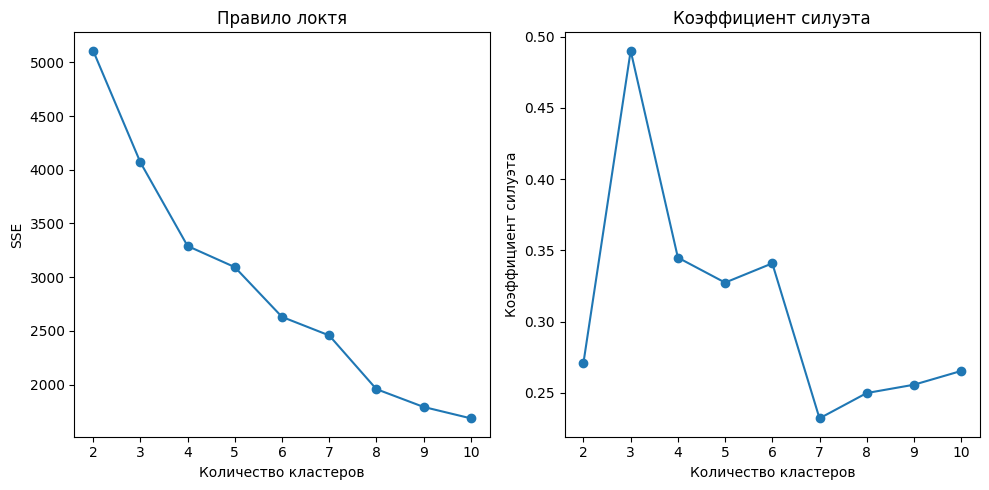

,likes_count,comments_count,reposts_count,views_count,kmeans_labels
0,2.437374,0.489365,1.150825,0.937108,2
1,-0.907849,-0.238972,-0.134222,-0.476778,0
2,-0.976119,-0.238972,-0.209813,-0.489247,0
3,-0.703040,-0.238972,0.092551,-0.378408,0
4,-0.634770,-0.238972,-0.209813,-0.272419,2


In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = df[numerical_features]

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

platform_encoded = encoder.fit_transform(df[['platform']])      # Преобразуем категориальные данные в числовые
platform_columns = encoder.get_feature_names_out(['platform'])  # Получаем имена новых столбцов

platform_df = pd.DataFrame(platform_encoded, columns=platform_columns)      # Преобразуем результат в DataFrame и добавляем его к исходным данным
df_encoded = pd.concat([df.drop('platform', axis=1), platform_df], axis=1)  # Объединяем новый DataFrame с закодированными платформами и основной DataFrame

cluster_range = range(2, 11)    # Определим диапазон количества кластеров, который будем проверять
sse = []  # Список для суммы квадратов ошибок (SSE)
silhouette_scores = []  # Список для коэффициентов силуэта

for k in cluster_range: # Проход по разным значениям количества кластеров и сохранение метрик
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_encoded)
    sse.append(kmeans.inertia_)     # SSE - сумма квадратов расстояний до ближайшего центра кластера
    # Коэффициент силуэта
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(df_encoded, labels))

plt.figure(figsize=(10, 5)) # Построение графика "Правило локтя"

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse, marker='o')
plt.title('Правило локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('SSE')

# Построение графика для коэффициента силуэта
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.tight_layout()
plt.show()

# Пример кластеризации с K-Means
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['kmeans_labels'] = kmeans.fit_predict(features)
df[['likes_count', 'comments_count', 'reposts_count', 'views_count', 'kmeans_labels']].head()

# Задание 3

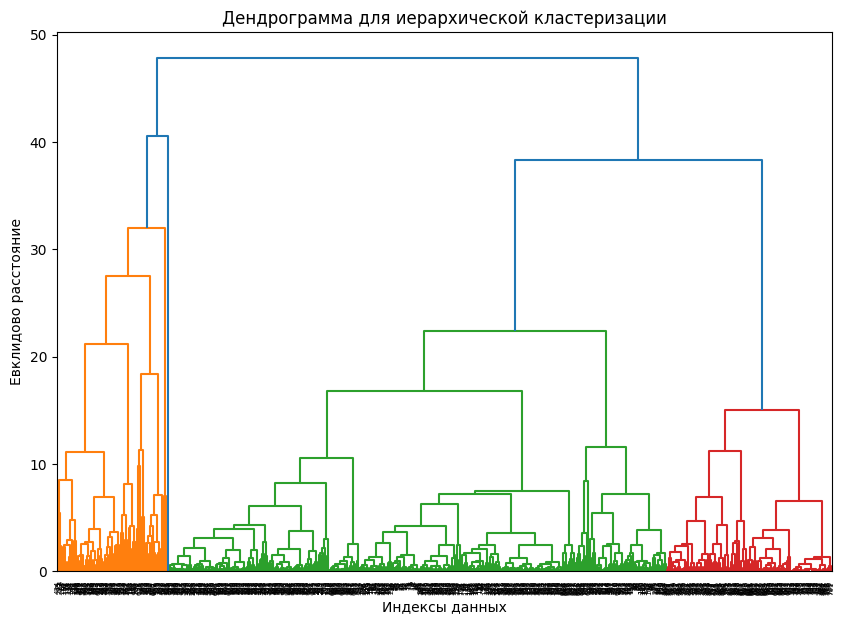

,likes_count,comments_count,reposts_count,views_count,hierarchical_labels
0,2.437374,0.489365,1.150825,0.937108,0
1,-0.907849,-0.238972,-0.134222,-0.476778,0
2,-0.976119,-0.238972,-0.209813,-0.489247,0
3,-0.703040,-0.238972,0.092551,-0.378408,0
4,-0.634770,-0.238972,-0.209813,-0.272419,1


In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Построение дендрограммы
def plot_dendrogram(data):
    linked = linkage(data, method='ward')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Дендрограмма для иерархической кластеризации')
    plt.xlabel('Индексы данных')
    plt.ylabel('Евклидово расстояние')
    plt.show()

# Иерархическая кластеризация
def hierarchical_clustering(data, n_clusters=3):
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = hc.fit_predict(data)
    return labels

# Построение дендрограммы
plot_dendrogram(features)

# Пример иерархической кластеризации с 3 кластерами
df['hierarchical_labels'] = hierarchical_clustering(features, n_clusters=3)

# Отображение первых строк с метками иерархической кластеризации
df[['likes_count', 'comments_count', 'reposts_count', 'views_count', 'hierarchical_labels']].head()


# Задание 4

   likes_count  comments_count  reposts_count  views_count  dbscan_labels
0     2.437374        0.489365       1.150825     0.937108             -1
1    -0.907849       -0.238972      -0.134222    -0.476778              0
2    -0.976119       -0.238972      -0.209813    -0.489247              0
3    -0.703040       -0.238972       0.092551    -0.378408              0
4    -0.634770       -0.238972      -0.209813    -0.272419             -1
Количество кластеров DBSCAN: 7


C:\Users\1\PycharmProjects\MIREA-TIIABD\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


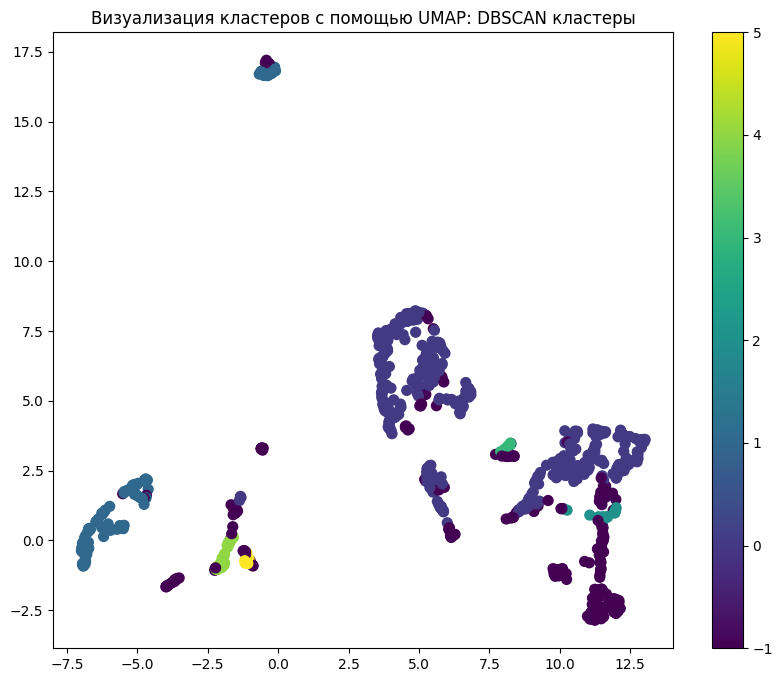

In [13]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Кластеризация с помощью DBSCAN
def dbscan_clustering(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return labels

# Пример кластеризации DBSCAN
df['dbscan_labels'] = dbscan_clustering(features, eps=0.7, min_samples=10)

# Отображение первых строк с метками DBSCAN
print(df[['likes_count', 'comments_count', 'reposts_count', 'views_count', 'dbscan_labels']].head())

# Вывод количества кластеров (не включая метку -1, которая означает шум)
print('Количество кластеров DBSCAN:', len(set(df['dbscan_labels'])) - (1 if -1 in df['dbscan_labels'] else 0))

# Визуализация кластеров DBSCAN с помощью UMAP
def visualize_umap(data, labels, title):
    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_results = umap_model.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels, cmap='viridis', s=50)
    plt.colorbar(scatter)
    plt.title(f'Визуализация кластеров с помощью UMAP: {title}')
    plt.show()

# Визуализация кластеров DBSCAN
visualize_umap(features, df['dbscan_labels'], title='DBSCAN кластеры')


# Задание 5

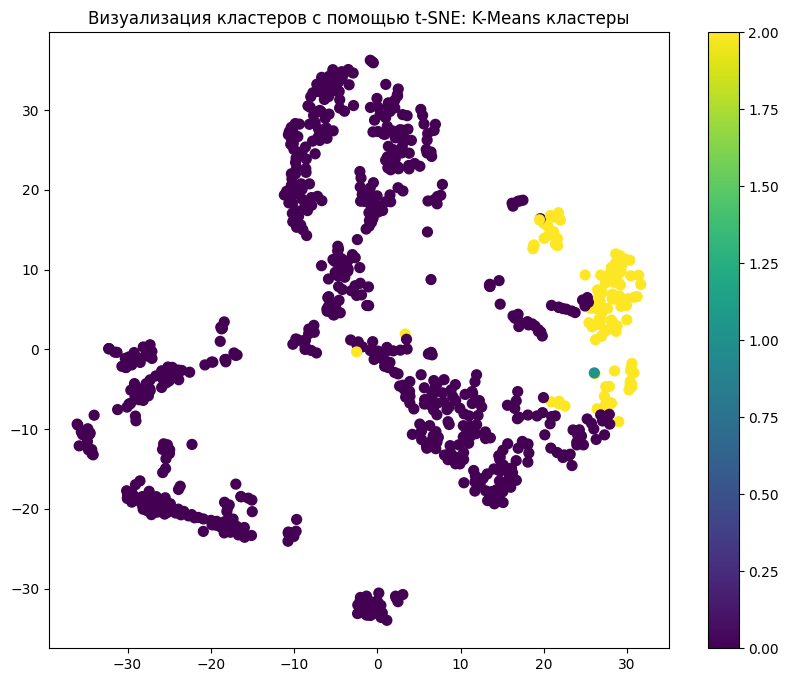

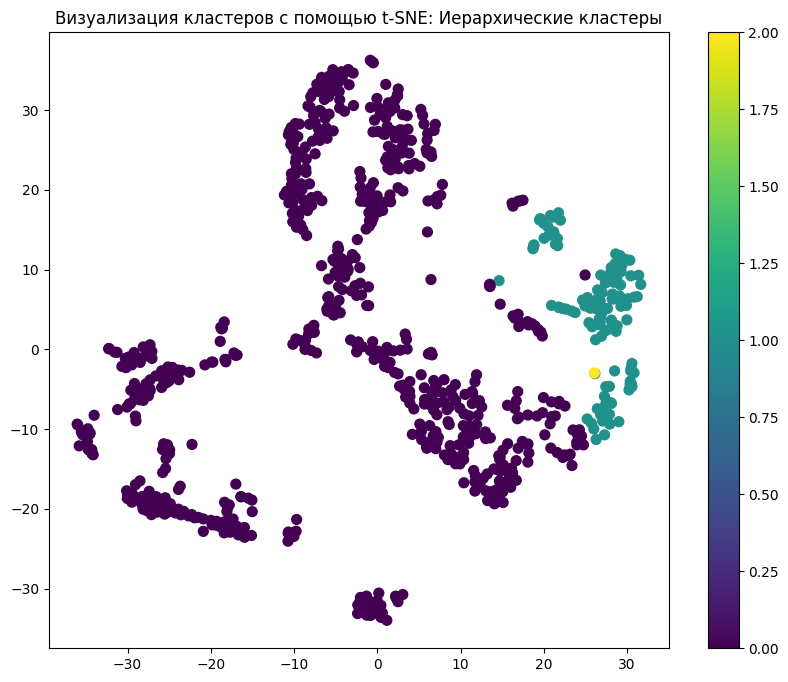

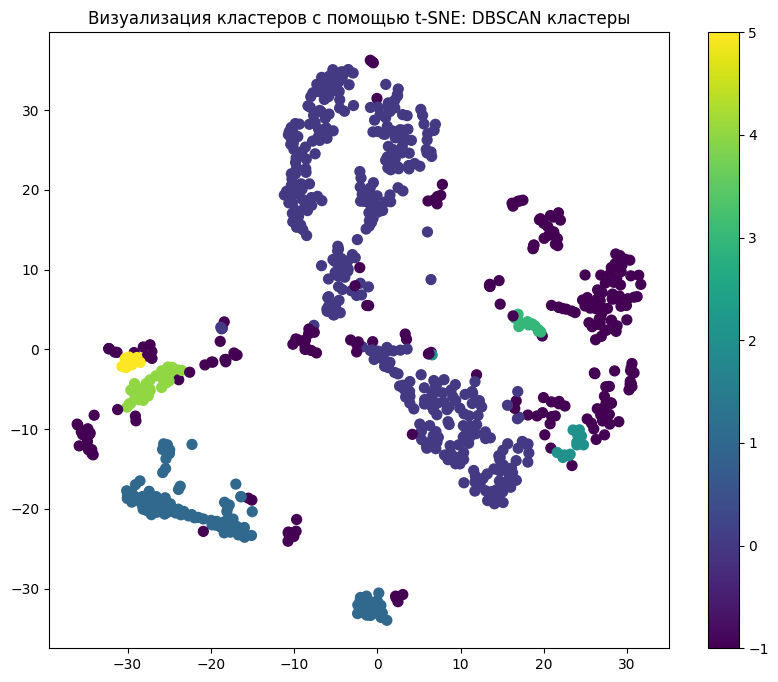

In [15]:
from sklearn.manifold import TSNE

# Визуализация данных с t-SNE
def visualize_tsne(data, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50)
    plt.colorbar(scatter)
    plt.title(f'Визуализация кластеров с помощью t-SNE: {title}')
    plt.show()

# Визуализация кластеров, созданных K-Means
visualize_tsne(features, df['kmeans_labels'], title='K-Means кластеры')

# Визуализация кластеров, созданных иерархической кластеризацией
visualize_tsne(features, df['hierarchical_labels'], title='Иерархические кластеры')

# Визуализация кластеров, созданных DBSCAN
visualize_tsne(features, df['dbscan_labels'], title='DBSCAN кластеры')
